# Metrics prediction  

This project consists of 2 parts.

## *Part 1*  
### Task description:  
Supporting and stimulating user activity is an important task for a product we are working with. To do this, a marketing team decided to organize a flash mob in the news feed: participants had to make a post where they shared an interesting fact about themselves and publish it with a hashtag. The three posts with the most likes would receive prizes.

In this project we are going to use CausalImpact, to conclude whether there is an effect of a flash mob or not — and how significant that effect is.

The flash mob ran from December 5, 2025, to December 11, 2025. Our task is to evaluate the effectiveness of this event.

In this part we are going to evaluate following metrics:  
- DAU
- CTR
- Number of views
- New posts 
- Unique views  

To keep things simple, we will use a basic model without seasonality, trends, or other modifications. 


In [1]:
import orbit 
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #for predictions viz

#general EDA libraries
import pandas as pd
import pandahouse as ph
import numpy as np
import os


#data viz
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #MCMC viz
#exploratory module
from orbit.eda import eda_plot

import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

from orbit.diagnostics.backtest import BackTester #backtest
from orbit.utils.params_tuning import grid_search_orbit #search for optimap parameters

2026-01-12 12:49:55.812617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 12:49:57.194263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### DB connect

In [ ]:
connection = {'host': '',
'database':'',
'user':'',
'password':''
}

## Query
Getting data for CalualImpact

In [3]:
q = '''
select _date, dau, views, ctr, unique_viewed_posts, ifNull(t2.posts_number, 0) AS posts_number
FROM
(select 
toDate(time) as _date,
count(distinct user_id) as dau,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr,
uniqExact(post_id) as unique_viewed_posts
from simulator_20251220.feed_actions
group by toDate(time)
order by toDate(time)) as t1
LEFT JOIN
-- publication_date
(select publication_date, count(post_id) as posts_number
from(
select min(toDate(time)) as publication_date, post_id
from simulator_20251220.feed_actions
where action = 'view'
group by post_id) as t
group by publication_date) as t2
ON t1._date=t2.publication_date
order by _date ASC
'''

df = ph.read_clickhouse(query=q, connection=connection)

df.set_index('_date',inplace=True)
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2025-10-25 to 2026-01-12
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dau                  80 non-null     uint64 
 1   views                80 non-null     uint64 
 2   ctr                  80 non-null     float64
 3   unique_viewed_posts  80 non-null     uint64 
 4   posts_number         80 non-null     uint64 
dtypes: float64(1), uint64(4)
memory usage: 3.8 KB


,dau,views,ctr,unique_viewed_posts,posts_number
_date,,,,,
2025-10-25,878,7603,0.205182,89,89
2025-10-26,2238,62770,0.204174,178,97
2025-10-27,3105,105526,0.198605,191,61
2025-10-28,3721,118996,0.200007,211,87
2025-10-29,4617,174454,0.197783,214,70


In [4]:
pre_period = [pd.Timestamp('2025-10-27'), pd.Timestamp('2025-12-04')] # selecting pre and post period
post_period = [pd.Timestamp('2025-12-05'), pd.Timestamp('2025-12-11')] 

## CausalImpact

 **We are going to predict a time series and then see how much the prediction differs from the actual values after a certain event.**.


### DAU

In [5]:
# DAU
impact_dau = CausalImpact(data=df['dau'], #данные
                      pre_period=pre_period, #период до события
                      post_period=post_period) #период после события

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2026-01-12 12:50:01.476990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2026-01-12 12:50:01.477407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2026-01-12 12:50:01.488425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2026-01-12 12:50:01.488770: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2026-01-12 12:50:01.888962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:02.580704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:02.617583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/Pa

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2026-01-12 12:50:17.706466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2026-01-12 12:50:17.791808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

Plot the result:

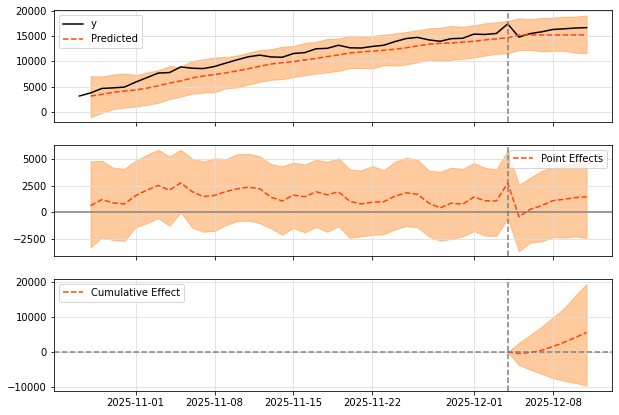

In [6]:
impact_dau.plot()

In [7]:
print(impact_dau.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15249.46 (1031.9)  106746.24 (7223.27)
95% CI                    [13164.16, 17209.12][92149.15, 120463.86]

Absolute effect (s.d.)    803.25 (1031.9)    5622.76 (7223.27)
95% CI                    [-1156.41, 2888.55][-8094.86, 20219.85]

Relative effect (s.d.)    5.27% (6.77%)      5.27% (6.77%)
95% CI                    [-7.58%, 18.94%]   [-7.58%, 18.94%]

Posterior tail-area probability p: 0.22
Posterior prob. of a causal effect: 77.82%

For more details run the command: print(impact.summary('report'))


In [8]:
print(impact_dau.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 15249.46.
The 95% interval of this counterfactual prediction is [13164.16, 17209.12].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 803.25 with a 95% interval of
[-1156.41, 2888.55]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 106746.24. The 95% interval of this prediction is [92149.15, 120463.86].


The above results are given in terms of absolute numbers. In relative
terms, the response vari

### CTR

In [9]:
# CTR
impact_ctr = CausalImpact(data=df['ctr'], #data
                      pre_period=pre_period, #pre-period
                      post_period=post_period) #post-period

2026-01-12 12:50:20.042360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:20.065318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:20.637965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:

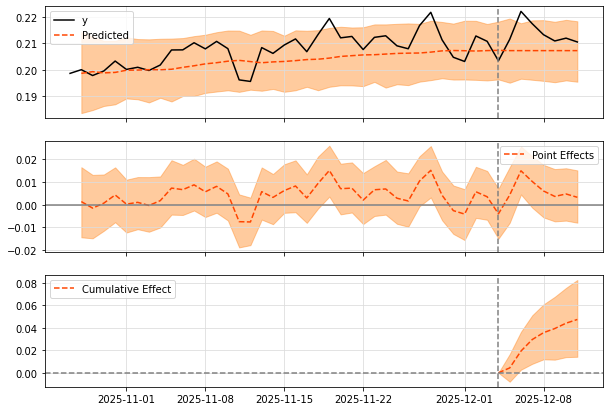

In [10]:
impact_ctr.plot()

In [11]:
print(impact_ctr.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.02)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.26% (1.1%)       3.26% (1.1%)
95% CI                    [1.09%, 5.41%]     [1.09%, 5.41%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.8%

For more details run the command: print(impact.summary('report'))


In [12]:
print(impact_ctr.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.2, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.45. The 95% interval of this prediction is [1.42, 1.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

### Views

In [13]:
# views
impact_views = CausalImpact(data=df['views'], 
                      pre_period=pre_period, 
                      post_period=post_period)

2026-01-12 12:50:36.991551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:37.014636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:37.570001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:

2026-01-12 12:50:52.039716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2026-01-12 12:50:52.123555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

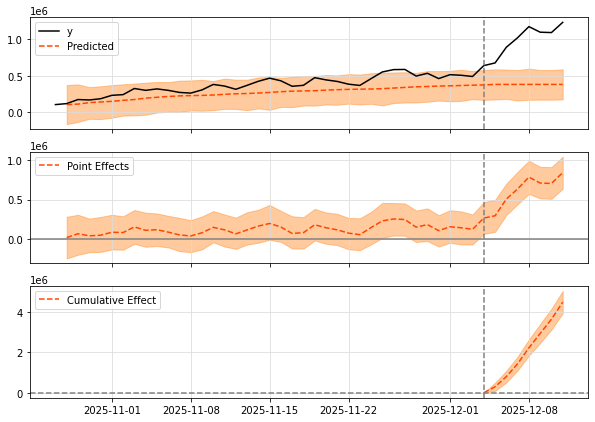

In [14]:
impact_views.plot()

In [15]:
print(impact_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         380294.97 (42723.08)2662064.75 (299061.53)
95% CI                    [296599.52, 464070.94][2076196.71, 3248496.61]

Absolute effect (s.d.)    639652.38 (42723.08)4477566.0 (299061.53)
95% CI                    [555876.37, 723347.8][3891134.39, 5063434.29]

Relative effect (s.d.)    168.2% (11.23%)    168.2% (11.23%)
95% CI                    [146.17%, 190.21%] [146.17%, 190.21%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [16]:
print(impact_views.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 380294.97.
The 95% interval of this counterfactual prediction is [296599.52, 464070.94].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 639652.38 with a 95% interval of
[555876.37, 723347.8]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7139631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 2662064.75. The 95% interval of this prediction is [2076196.71, 3248496.61].


The above results are given in terms of absolute numb

### New posts

In [17]:
# new posts
impact_posts = CausalImpact(data=df['posts_number'], 
                      pre_period=pre_period, 
                      post_period=post_period) 

2026-01-12 12:50:54.249554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:54.272247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:50:54.797603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:

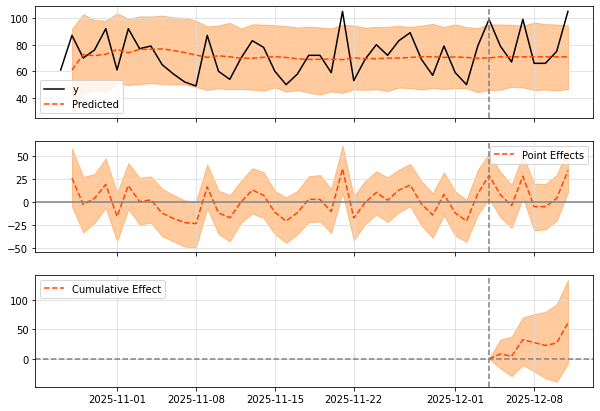

In [18]:
impact_posts.plot()

In [19]:
print(impact_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.57              557.0
Prediction (s.d.)         70.88 (5.02)       496.13 (35.17)
95% CI                    [61.15, 80.84]     [428.03, 565.89]

Absolute effect (s.d.)    8.7 (5.02)         60.87 (35.17)
95% CI                    [-1.27, 18.42]     [-8.89, 128.97]

Relative effect (s.d.)    12.27% (7.09%)     12.27% (7.09%)
95% CI                    [-1.79%, 26.0%]    [-1.79%, 26.0%]

Posterior tail-area probability p: 0.04
Posterior prob. of a causal effect: 96.2%

For more details run the command: print(impact.summary('report'))


In [20]:
print(impact_posts.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 79.57. In the absence of an
intervention, we would have expected an average response of 70.88.
The 95% interval of this counterfactual prediction is [61.15, 80.84].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 8.7 with a 95% interval of
[-1.27, 18.42]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 557.0.
Had the intervention not taken place, we would have expected
a sum of 496.13. The 95% interval of this prediction is [428.03, 565.89].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +12.

### Unique viewed posts

In [21]:
# unique posts
impact_unique_posts = CausalImpact(data=df['unique_viewed_posts'], 
                      pre_period=pre_period, 
                      post_period=post_period)

2026-01-12 12:51:11.995684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:51:12.019050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:51:12.566069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2026-01-12 12:

2026-01-12 12:51:26.611662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2026-01-12 12:51:26.730438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

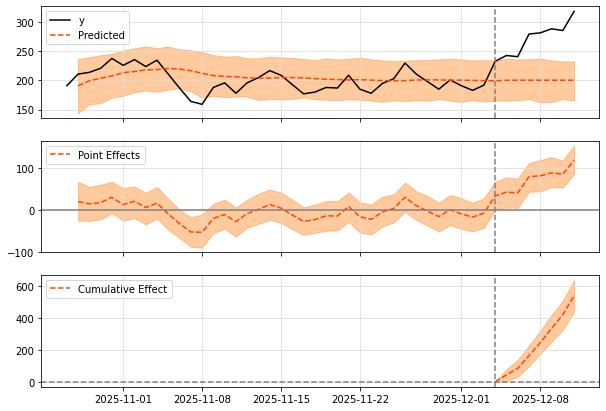

In [22]:
impact_unique_posts.plot()

In [23]:
print(impact_unique_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    277.14             1940.0
Prediction (s.d.)         200.46 (7.04)      1403.2 (49.27)
95% CI                    [186.9, 214.49]    [1308.3, 1501.43]

Absolute effect (s.d.)    76.69 (7.04)       536.8 (49.27)
95% CI                    [62.65, 90.24]     [438.57, 631.7]

Relative effect (s.d.)    38.26% (3.51%)     38.26% (3.51%)
95% CI                    [31.26%, 45.02%]   [31.26%, 45.02%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [24]:
print(impact_unique_posts.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 277.14. By contrast, in the absence of an
intervention, we would have expected an average response of 200.46.
The 95% interval of this counterfactual prediction is [186.9, 214.49].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 76.69 with a 95% interval of
[62.65, 90.24]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1940.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1403.2. The 95% interval of this prediction is [1308.3, 1501.43].


The above results are given in terms of absolute numbers. In relative
terms, the response va

## Conclusion  

DAU did not change significantly. The average absolute effect is approximately 803. CTR increased, but insignificantly. The average absolute effect is approximately 0.01. The number of views increased significantly. The average absolute effect is approximately 659,639,652.  
The number of new posts has not changed significantly. The average absolute effect is approximately 8.  
The number of unique posts viewed has increased significantly. The average absolute effect is approximately 76.  


# Problem 2

The more active our users are, the higher the load on the servers. Recently, we have been receiving more and more complaints that the application is freezing. You have been asked to contribute to the task — **to predict how user activity will change over the next month.**  

A metric we are going to prognose is **number of actions per hour**. The metric indicates how much users are interacting with the app every hour prviding high server load. As an addition, we know that on 04.12.25 we launched an advertising campaign, which lead to lots of new users. On 13.12.25 there was a problem with interaction with the platform in cities of Russia. 05.12.2025-11.12.2025 flash mob with increased number of interactions with the platform
and New Year holidays may have an impact (31.12.2025-12.01.2026). These known events we incluse as regressors to the model


### Load the data
At first we are loading our data on actions per hour

In [25]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    count(action) hour_action
FROM 
    simulator_20251220.feed_actions
GROUP BY hour_time
ORDER BY 
    hour_time
'''

In [26]:
actions = ph.read_clickhouse(query=query, connection=connection)
actions.head()

,hour_time,hour_action
0,2025-10-25 00:00:00,22
1,2025-10-25 01:00:00,32
2,2025-10-25 02:00:00,24
3,2025-10-25 03:00:00,11
4,2025-10-25 04:00:00,18


In [27]:
print('We have data for', actions['hour_time'].max()-actions['hour_time'].min())

We have data for 79 days 15:00:00


In [28]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   hour_time    1912 non-null   datetime64[ns]
 1   hour_action  1912 non-null   uint64        
dtypes: datetime64[ns](1), uint64(1)
memory usage: 30.0 KB


In [29]:
# set plot style
sns.set(rc={'figure.figsize':(20,15)}, style="whitegrid")

<Axes: xlabel='hour_time', ylabel='hour_action'>

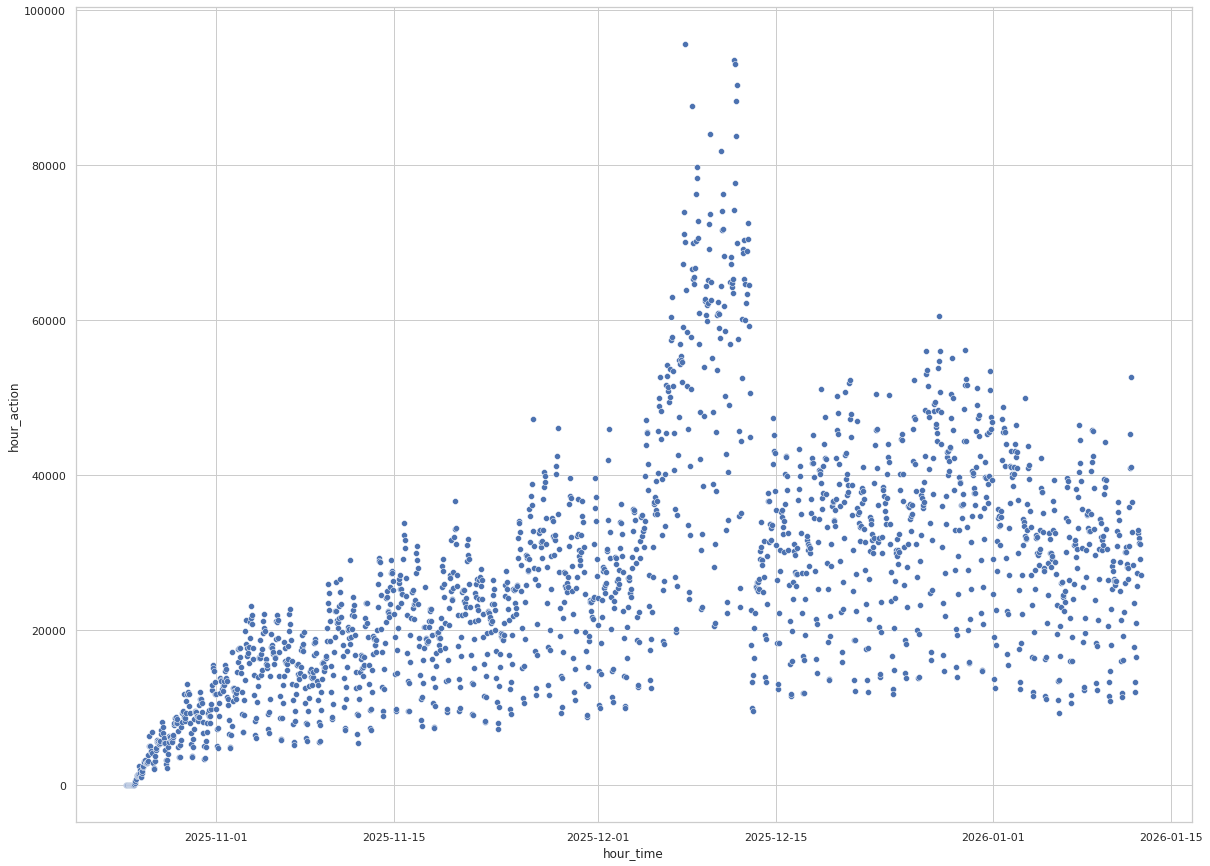

In [30]:
#how actions change with time
sns.scatterplot(x="hour_time", y="hour_action", data=actions)

On the graph we can clearly see peaks between 4-13.12.2025 when the new adv campaign was launched, then new users came and our app faced issues in Russia which lead to activity drop.

Let's have a look at heatmap of the actions.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

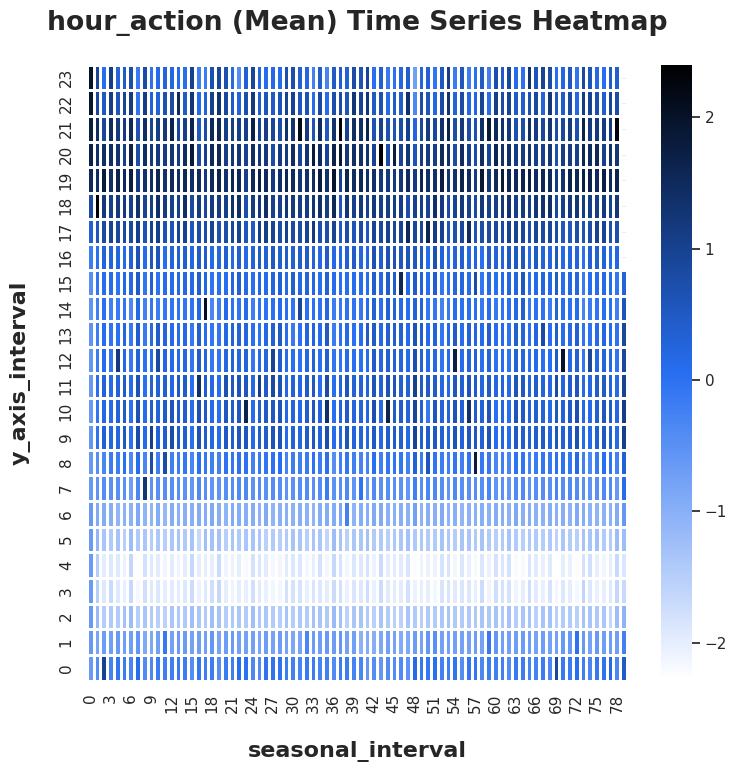

In [31]:
#heatmap
_ = eda_plot.ts_heatmap(df=actions, date_col="hour_time", value_col="hour_action", seasonal_interval=24, normalization=True)

The heatmap indicates that we have higher load on the app in the evening between 5-10 pm and almost zero iteractions at night between 3-4 am. 

### Prediction

We will use Damped Local Trend model known for its speed and reasonably good prediction quality. By varying its parameters we try to find the best model and make a prediction

In [32]:
def fit_predict_and_plot(
    model,
    df,
    forecast_days=30,
    date_col="hour_time",
    target_col="hour_action",
    freq_per_day=24
):
    """
    Fit Orbit model, make forecast,
    plot prediction and decomposition.
    """
    
    # Train model
    model.fit(df)
    
    # Future dataframe
    future_df = model.make_future_df(periods=freq_per_day * forecast_days)
    
    # Prediction
    predicted_df = model.predict(df=future_df)
    
    print("Prediction head():")
    display(predicted_df.head())
    
    # Prediction plot
    _ = plot_predicted_data(
        df,
        predicted_df,
        date_col,
        target_col,
        title=f"Prediction with {model.__class__.__name__}"
    )
    
    # Prediction with decomposition
    predicted_decomp_df = model.predict(
        df=future_df,
        decompose=True
    )
    
    print("Decomposition head():")
    display(predicted_decomp_df.head())
    
    # Decomposition plot
    _ = plot_predicted_components(
        predicted_decomp_df,
        date_col,
        plot_components=['prediction', 'trend', 'seasonality']
    )


**We are going to build first models with stan-map estimator since it is known for fast calculations compared, for example, to stan-mcmc. Then, based on model with optimal parameters obtained we calculate result with regressors and stan-mcmc estimator to find out the best model**

### Model 1: DLT, stan-map, no regressors


In [33]:
dlt = DLT(response_col="hour_action", #a metric to be predicted
          date_col="hour_time", #time column
          seasonality=24, #seasonal interval
          estimator="stan-map", 
          n_bootstrap_draws=1000) 

2026-01-12 12:51:32 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


Prediction head():


,hour_time,prediction_5,prediction,prediction_95
0,2026-01-12 16:00:00,26676.636610,30807.958980,34663.287554
1,2026-01-12 17:00:00,32058.616118,36233.069428,40670.157434
2,2026-01-12 18:00:00,35078.768220,40197.679936,45218.066468
3,2026-01-12 19:00:00,39695.932408,45156.450492,51157.110595
4,2026-01-12 20:00:00,36944.725330,42963.621086,49421.138358


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

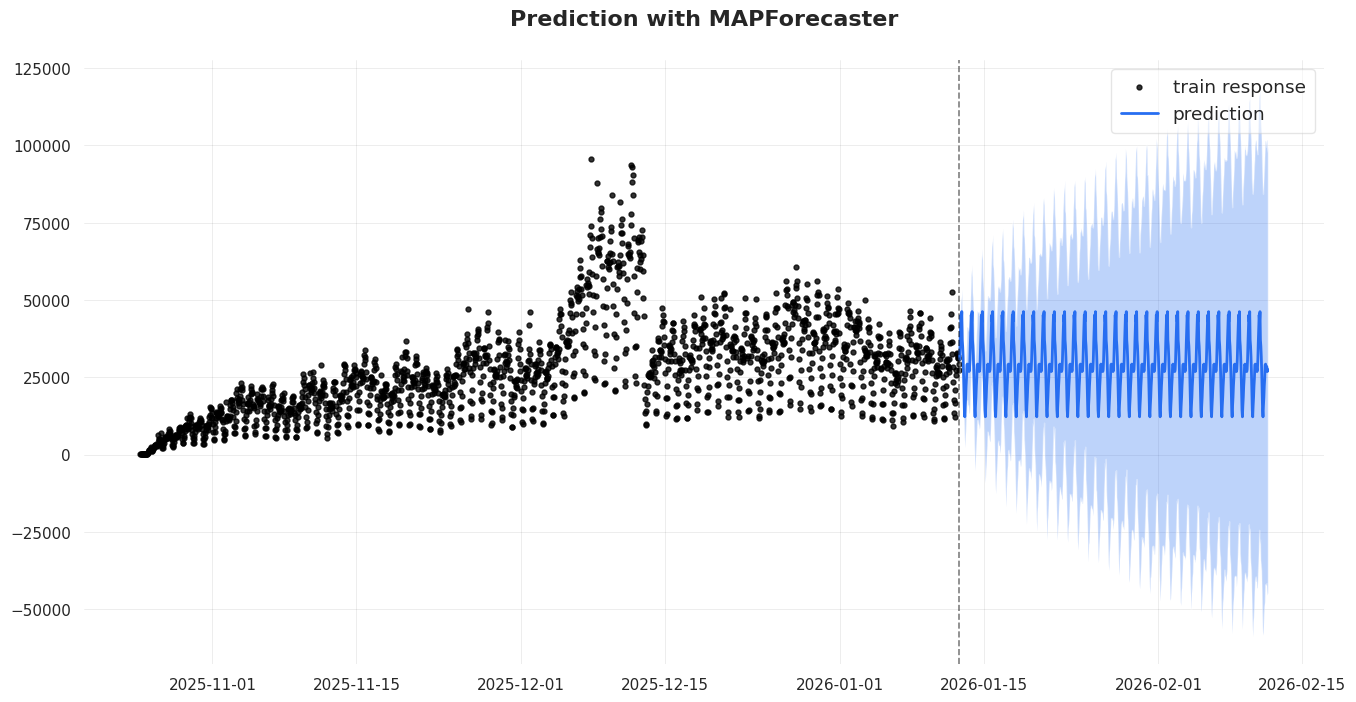

Decomposition head():


,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2026-01-12 16:00:00,27049.271545,30807.958980,34560.568226,24788.651545,28547.338980,32299.948226,2260.62,2260.62,2260.62,0.0,0.0,0.0
1,2026-01-12 17:00:00,31748.491217,36233.069428,40996.520739,24062.731217,28547.309428,33310.760739,7685.76,7685.76,7685.76,0.0,0.0,0.0
2,2026-01-12 18:00:00,35205.515358,40197.679936,45744.153538,23555.115358,28547.279936,34093.753538,11650.40,11650.40,11650.40,0.0,0.0,0.0
3,2026-01-12 19:00:00,39124.873768,45156.450492,51216.616675,22515.673768,28547.250492,34607.416675,16609.20,16609.20,16609.20,0.0,0.0,0.0
4,2026-01-12 20:00:00,36753.634207,42963.621086,49307.422591,22337.234207,28547.221086,34891.022591,14416.40,14416.40,14416.40,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

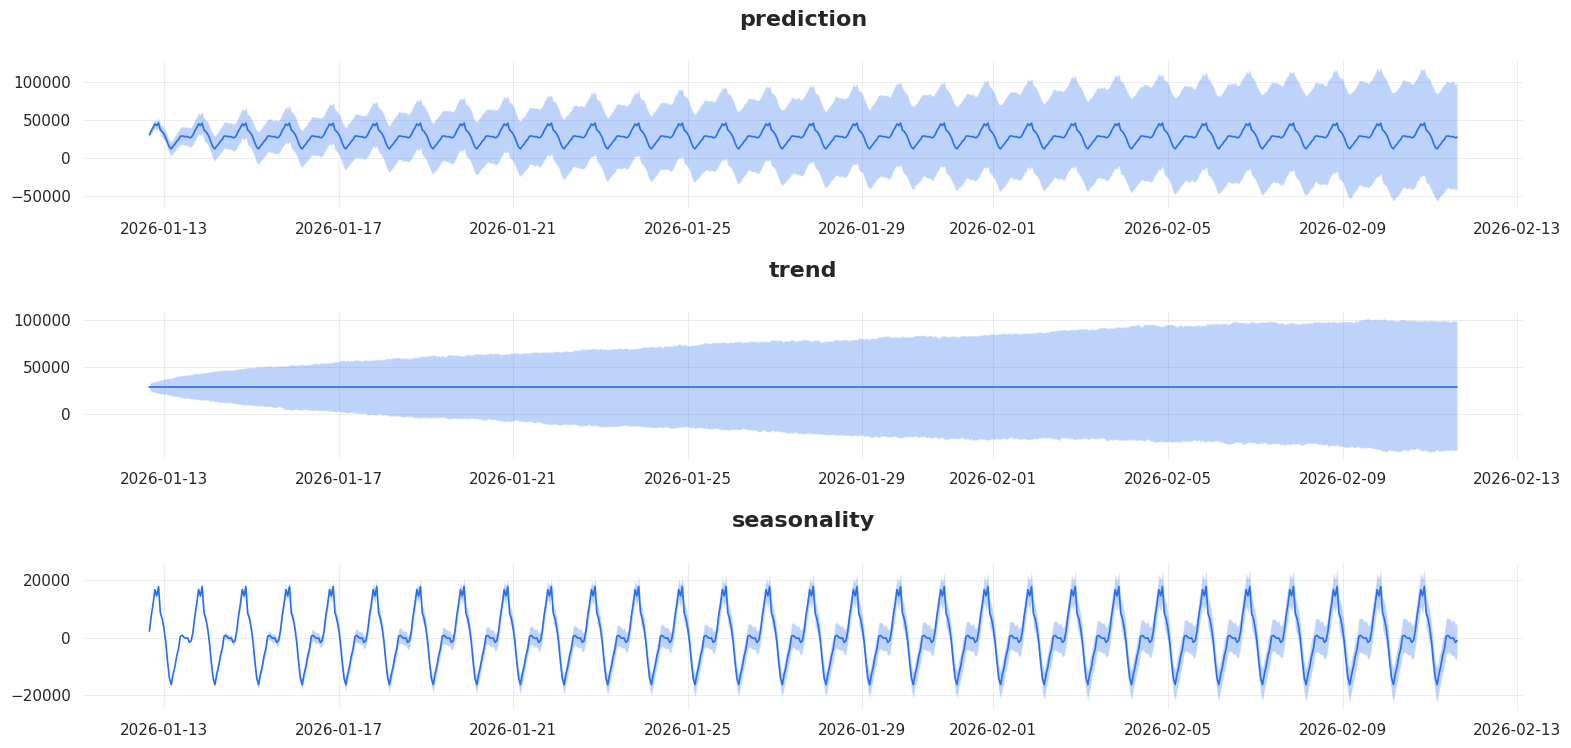

In [34]:
fit_predict_and_plot(
    model=dlt,
    df=actions)

Here we clearly see that prediction for 30 days gives increasing error for our forecast. The error is so large that its confidence interval exceeds the initial volatility of the data, caused, for example, by an advertising campaign.

### Model 2: DLT, stan-map, no regressors, regression penalty is fixed_ridge

In [35]:
dlt_rp = DLT(response_col="hour_action", #a metric to be predicted
          date_col="hour_time", #time column
          seasonality=24, #seasonal interval
          regression_penalty='fixed_ridge',
          estimator="stan-map", 
          n_bootstrap_draws=1000) 

2026-01-12 12:51:39 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


Prediction head():


,hour_time,prediction_5,prediction,prediction_95
0,2026-01-12 16:00:00,26676.636610,30807.958980,34663.287554
1,2026-01-12 17:00:00,32058.616118,36233.069428,40670.157434
2,2026-01-12 18:00:00,35078.768220,40197.679936,45218.066468
3,2026-01-12 19:00:00,39695.932408,45156.450492,51157.110595
4,2026-01-12 20:00:00,36944.725330,42963.621086,49421.138358


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

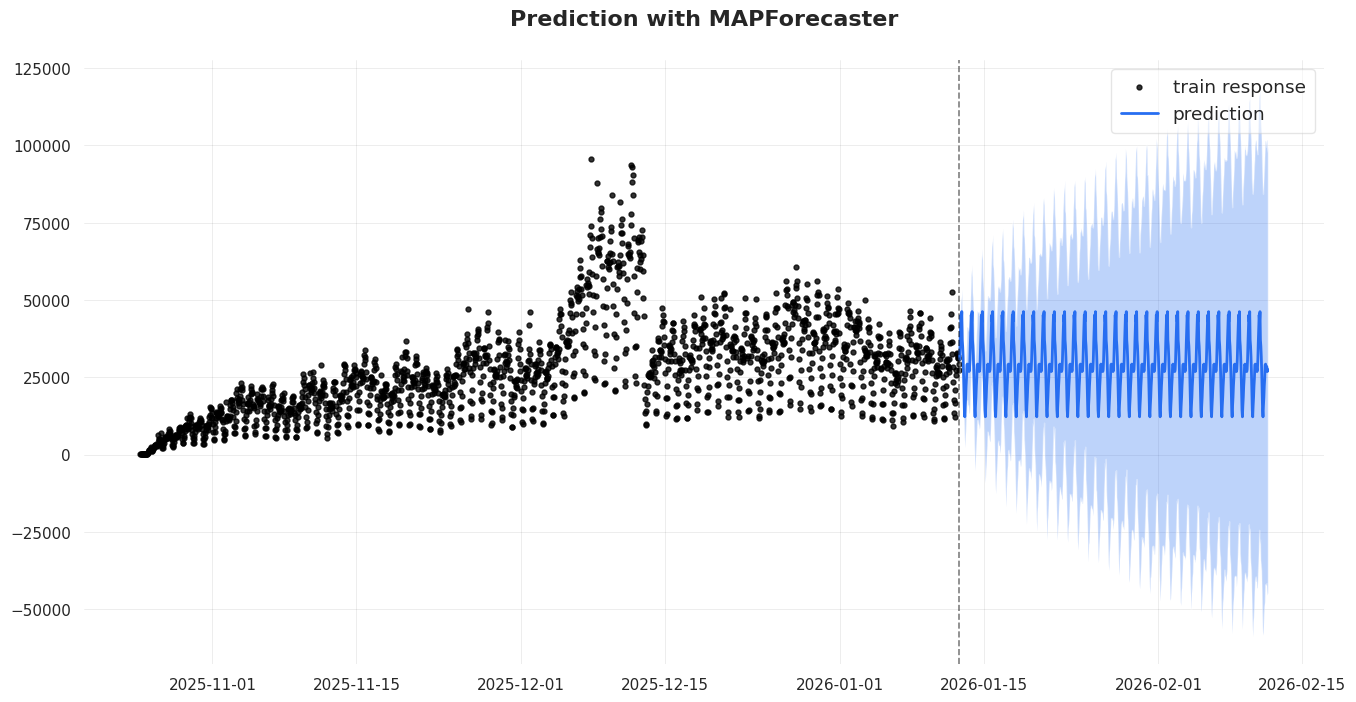

Decomposition head():


,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2026-01-12 16:00:00,27049.271545,30807.958980,34560.568226,24788.651545,28547.338980,32299.948226,2260.62,2260.62,2260.62,0.0,0.0,0.0
1,2026-01-12 17:00:00,31748.491217,36233.069428,40996.520739,24062.731217,28547.309428,33310.760739,7685.76,7685.76,7685.76,0.0,0.0,0.0
2,2026-01-12 18:00:00,35205.515358,40197.679936,45744.153538,23555.115358,28547.279936,34093.753538,11650.40,11650.40,11650.40,0.0,0.0,0.0
3,2026-01-12 19:00:00,39124.873768,45156.450492,51216.616675,22515.673768,28547.250492,34607.416675,16609.20,16609.20,16609.20,0.0,0.0,0.0
4,2026-01-12 20:00:00,36753.634207,42963.621086,49307.422591,22337.234207,28547.221086,34891.022591,14416.40,14416.40,14416.40,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

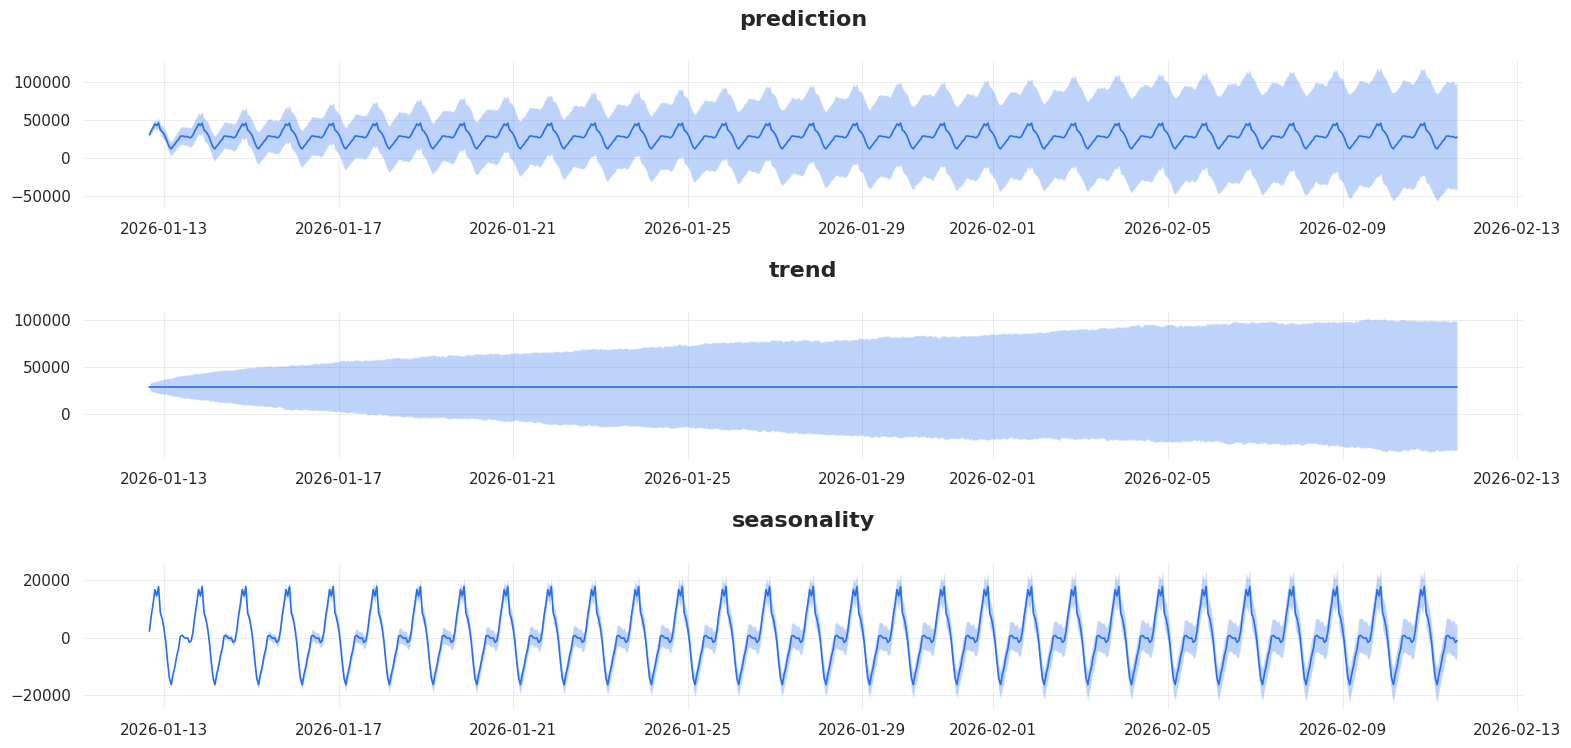

In [36]:
fit_predict_and_plot(
    model=dlt_rp,
    df=actions)

The DLT (stan-map, fixed-ridge) model has the same forecast characteristics as model 1. 

### Model 3: DLT, stan-map, no regressors, regression penalty is auto_ridge

In [37]:
dlt_auto = DLT(response_col="hour_action", #a metric to be predicted
          date_col="hour_time", #time column
          seasonality=24, #seasonal interval
          regression_penalty='auto_ridge',
          estimator="stan-map", 
          n_bootstrap_draws=1000) 

2026-01-12 12:51:44 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


Prediction head():


,hour_time,prediction_5,prediction,prediction_95
0,2026-01-12 16:00:00,26676.636610,30807.958980,34663.287554
1,2026-01-12 17:00:00,32058.616118,36233.069428,40670.157434
2,2026-01-12 18:00:00,35078.768220,40197.679936,45218.066468
3,2026-01-12 19:00:00,39695.932408,45156.450492,51157.110595
4,2026-01-12 20:00:00,36944.725330,42963.621086,49421.138358


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

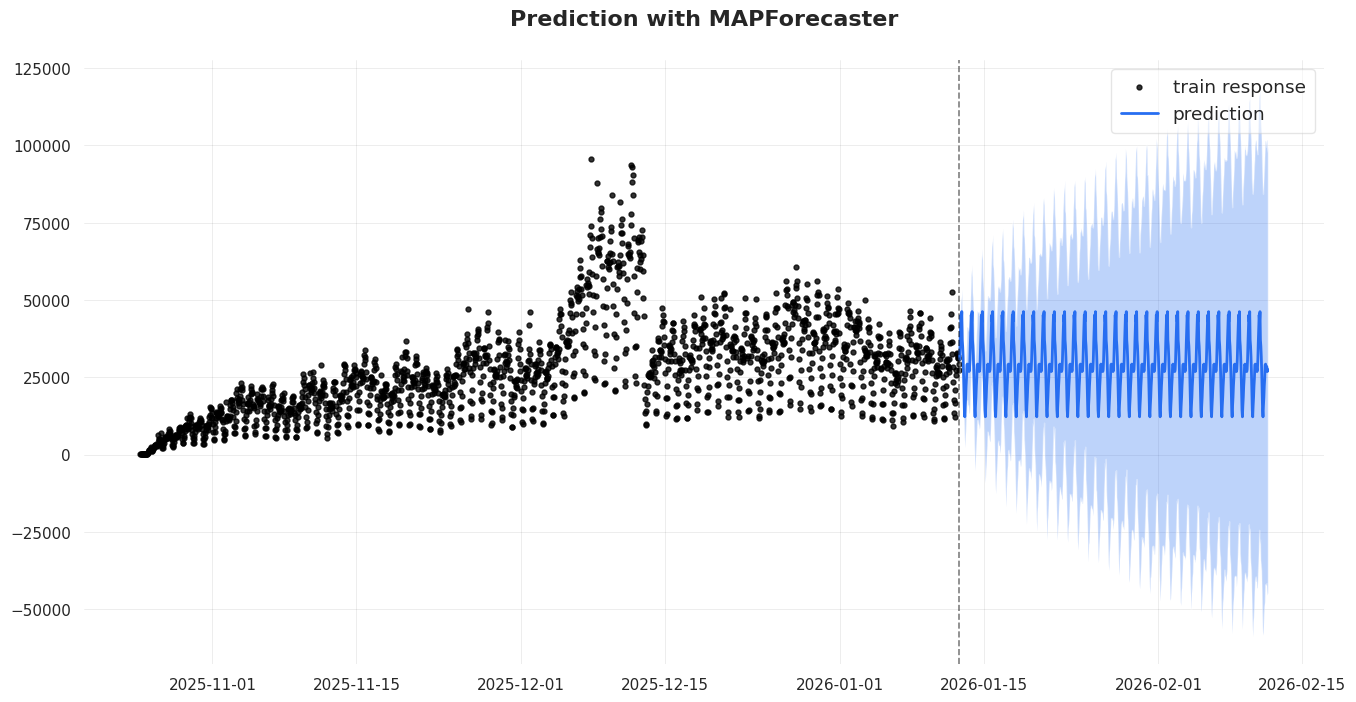

Decomposition head():


,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2026-01-12 16:00:00,27049.271545,30807.958980,34560.568226,24788.651545,28547.338980,32299.948226,2260.62,2260.62,2260.62,0.0,0.0,0.0
1,2026-01-12 17:00:00,31748.491217,36233.069428,40996.520739,24062.731217,28547.309428,33310.760739,7685.76,7685.76,7685.76,0.0,0.0,0.0
2,2026-01-12 18:00:00,35205.515358,40197.679936,45744.153538,23555.115358,28547.279936,34093.753538,11650.40,11650.40,11650.40,0.0,0.0,0.0
3,2026-01-12 19:00:00,39124.873768,45156.450492,51216.616675,22515.673768,28547.250492,34607.416675,16609.20,16609.20,16609.20,0.0,0.0,0.0
4,2026-01-12 20:00:00,36753.634207,42963.621086,49307.422591,22337.234207,28547.221086,34891.022591,14416.40,14416.40,14416.40,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

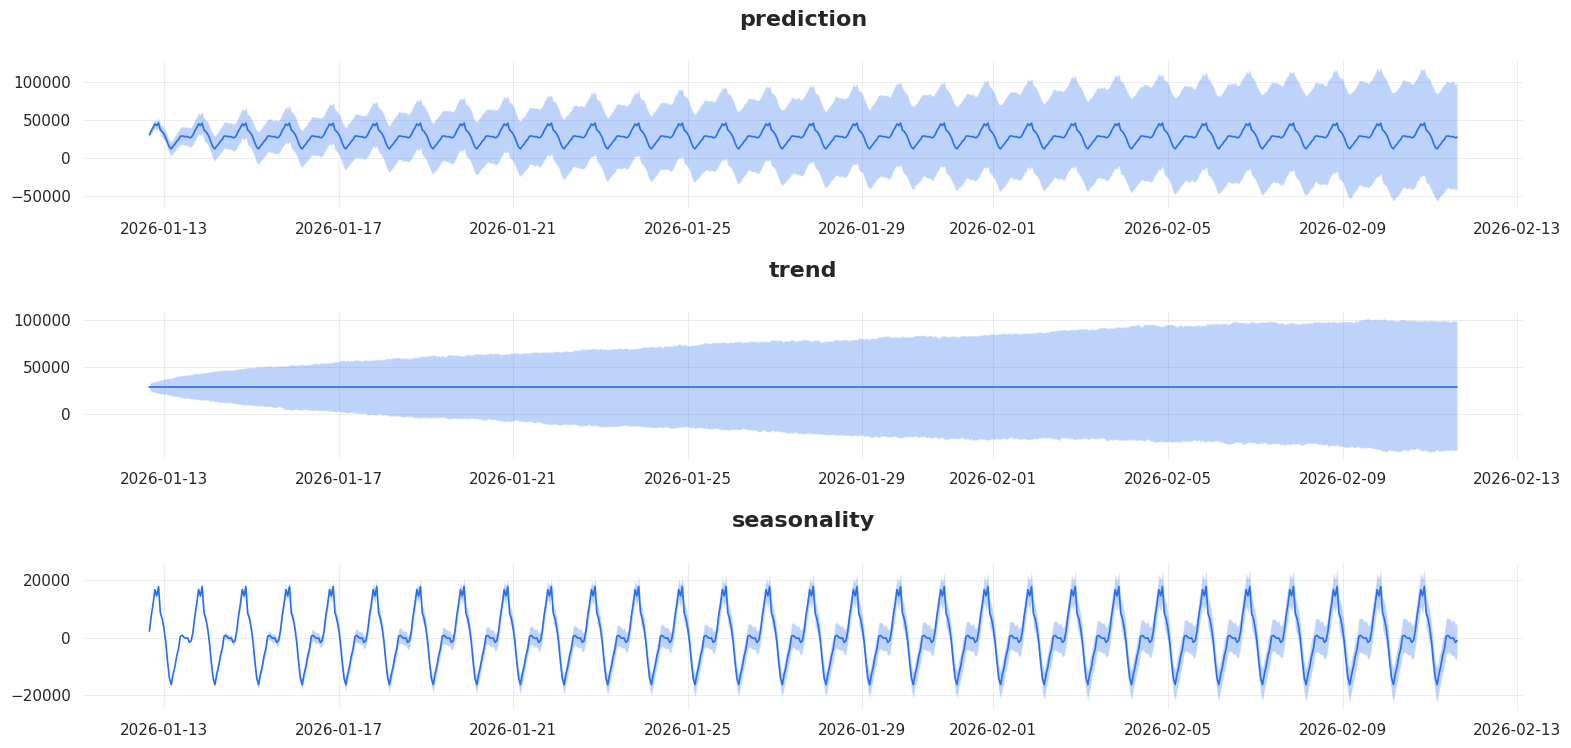

In [38]:
fit_predict_and_plot(
    model=dlt_auto,
    df=actions)

Again, the obtained forecast looks similar to models 1-2

### Model 4: DLT, stan-map, nor regressors, lasso for regression penalty

In [39]:
dlt_lasso = DLT(response_col="hour_action", #a metric to be predicted
          date_col="hour_time", #time column
          seasonality=24, #seasonal interval
          regression_penalty='lasso',
          estimator="stan-map", 
          n_bootstrap_draws=1000) 

2026-01-12 12:51:50 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


Prediction head():


,hour_time,prediction_5,prediction,prediction_95
0,2026-01-12 16:00:00,26676.636610,30807.958980,34663.287554
1,2026-01-12 17:00:00,32058.616118,36233.069428,40670.157434
2,2026-01-12 18:00:00,35078.768220,40197.679936,45218.066468
3,2026-01-12 19:00:00,39695.932408,45156.450492,51157.110595
4,2026-01-12 20:00:00,36944.725330,42963.621086,49421.138358


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

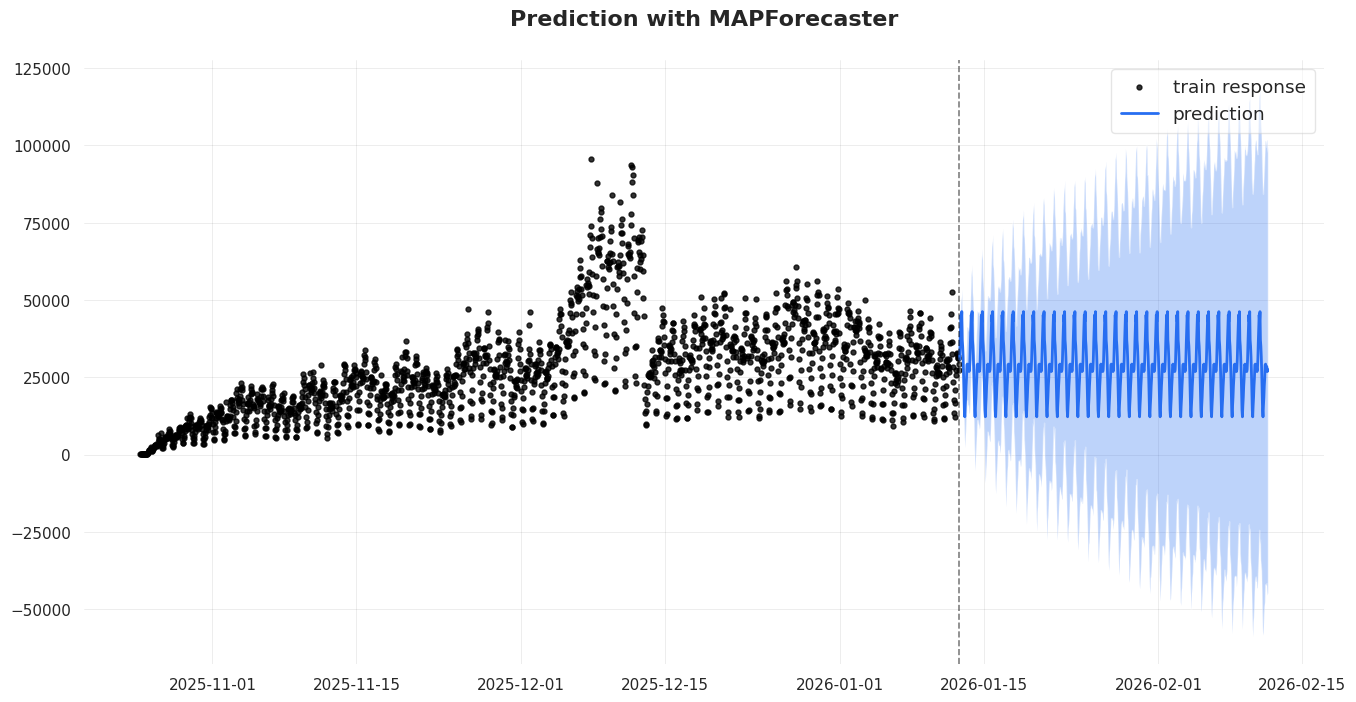

Decomposition head():


,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2026-01-12 16:00:00,27049.271545,30807.958980,34560.568226,24788.651545,28547.338980,32299.948226,2260.62,2260.62,2260.62,0.0,0.0,0.0
1,2026-01-12 17:00:00,31748.491217,36233.069428,40996.520739,24062.731217,28547.309428,33310.760739,7685.76,7685.76,7685.76,0.0,0.0,0.0
2,2026-01-12 18:00:00,35205.515358,40197.679936,45744.153538,23555.115358,28547.279936,34093.753538,11650.40,11650.40,11650.40,0.0,0.0,0.0
3,2026-01-12 19:00:00,39124.873768,45156.450492,51216.616675,22515.673768,28547.250492,34607.416675,16609.20,16609.20,16609.20,0.0,0.0,0.0
4,2026-01-12 20:00:00,36753.634207,42963.621086,49307.422591,22337.234207,28547.221086,34891.022591,14416.40,14416.40,14416.40,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

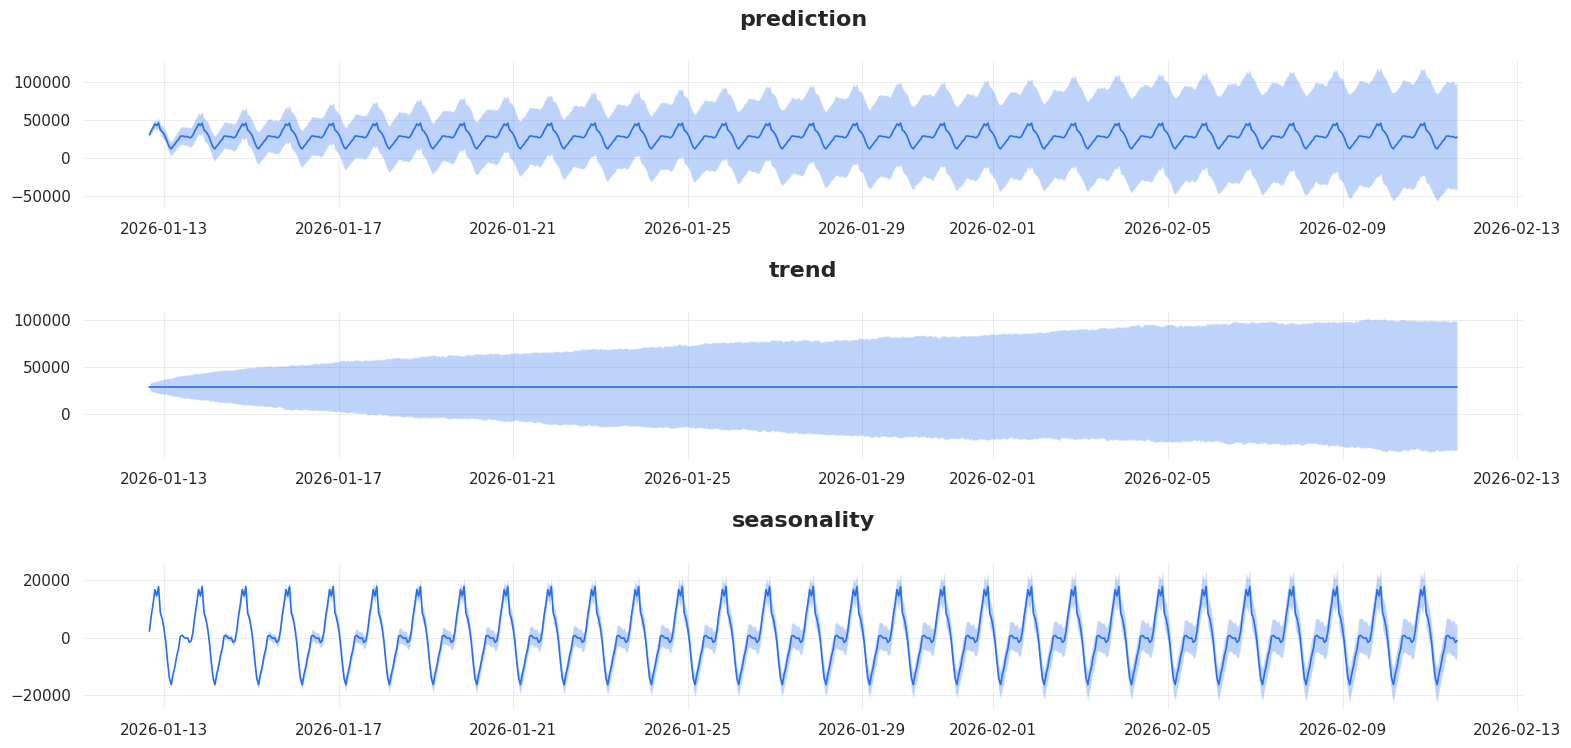

In [40]:
fit_predict_and_plot(
    model=dlt_lasso,
    df=actions)

### Backtest models 1-4

In [41]:
def backtest_models(
    models: dict,
    data: pd.DataFrame,
    min_train_len: int,
    incremental_len: int,
    forecast_len: int,
    window_type: str = "expanding"
):
    """
    models: dict {model_name: model_object}
    The function takes model name and do backtest for it.
    As a result we have df with metrics
    """

    all_results = []

    for name, model in models.items():
        print(f"\n===== Backtesting model: {name} =====")

        bt = BackTester(
            model=model,
            df=data,
            min_train_len=min_train_len,
            incremental_len=incremental_len,
            forecast_len=forecast_len,
            window_type=window_type
        )

        bt.fit_predict()
        score_df = bt.score()

        # добавляем имя модели
        score_df['model'] = name
        all_results.append(score_df)

        display(score_df)

    final_scores = pd.concat(all_results, ignore_index=True)
    return final_scores


**We have data for approximately 79 days. Which means that we do not have enough data for backtest for 30 days (train data is only 2,5 times bigger, whereas normally it should be 4 times bigger for train/test data split). Hence, we set min_train_len as 4 weeks, but forecast is 1 week.**

In [42]:
models = {
    "DLT_base": dlt,
    "DLT_stan-map_fixed_ridge": dlt_rp,
    "DLT_stan-map_auto_ridge": dlt_auto,
    "DLT_stan-map_lasso_regression_penalty": dlt_lasso
}

metrics_df = backtest_models(
    models=models,
    data=actions,
    min_train_len=24*7*4,
    incremental_len=24*7,
    forecast_len=24*7
)



===== Backtesting model: DLT_base =====


,metric_name,metric_values,is_training_metric,model
0,smape,2.304073e-01,False,DLT_base
1,wmape,2.442413e-01,False,DLT_base
2,mape,2.550988e-01,False,DLT_base
3,mse,1.298749e+08,False,DLT_base
4,mae,8.230369e+03,False,DLT_base
5,rmsse,2.310914e+00,False,DLT_base



===== Backtesting model: DLT_stan-map_fixed_ridge =====


,metric_name,metric_values,is_training_metric,model
0,smape,2.304075e-01,False,DLT_stan-map_fixed_ridge
1,wmape,2.442350e-01,False,DLT_stan-map_fixed_ridge
2,mape,2.550944e-01,False,DLT_stan-map_fixed_ridge
3,mse,1.298689e+08,False,DLT_stan-map_fixed_ridge
4,mae,8.230159e+03,False,DLT_stan-map_fixed_ridge
5,rmsse,2.310860e+00,False,DLT_stan-map_fixed_ridge



===== Backtesting model: DLT_stan-map_auto_ridge =====


,metric_name,metric_values,is_training_metric,model
0,smape,2.273331e-01,False,DLT_stan-map_auto_ridge
1,wmape,2.447359e-01,False,DLT_stan-map_auto_ridge
2,mape,2.504980e-01,False,DLT_stan-map_auto_ridge
3,mse,1.350132e+08,False,DLT_stan-map_auto_ridge
4,mae,8.247037e+03,False,DLT_stan-map_auto_ridge
5,rmsse,2.356184e+00,False,DLT_stan-map_auto_ridge



===== Backtesting model: DLT_stan-map_lasso_regression_penalty =====


,metric_name,metric_values,is_training_metric,model
0,smape,2.273181e-01,False,DLT_stan-map_lasso_regression_penalty
1,wmape,2.447281e-01,False,DLT_stan-map_lasso_regression_penalty
2,mape,2.504869e-01,False,DLT_stan-map_lasso_regression_penalty
3,mse,1.350112e+08,False,DLT_stan-map_lasso_regression_penalty
4,mae,8.246775e+03,False,DLT_stan-map_lasso_regression_penalty
5,rmsse,2.356167e+00,False,DLT_stan-map_lasso_regression_penalty


Let's see also BIC results for the same models to evaluate models quality:

In [43]:
print(f"DLT, stan-map: {dlt.get_bic()}")
print(f"DLT, stan-map, mo regressors, fixed_ridge: {dlt_rp.get_bic()}")
print(f"DLT, stan-map, mo regressors, auto_ridge: {dlt_auto.get_bic()}")
print(f"DLT, stan-map, mo regressors, lasso_ridge: {dlt_lasso.get_bic()}")

DLT, stan-map: 35405.53546333089
DLT, stan-map, mo regressors, fixed_ridge: 35405.53546333089
DLT, stan-map, mo regressors, auto_ridge: 35405.53546333089
DLT, stan-map, mo regressors, lasso_ridge: 35405.53546333089


For forecast evaluation we're going to use **MSE**. If prediction is far from real value, the metric has higher value. Based on this, all DLT models show close results. We add auto-ridge regression penalty to further experiments. Based on BIC criteria, we do not have difference between all these models.

### Model 5: DLT but with regressors and regression penalty

 For regressors:  
as an addition, we know that on 04.12.25 we launched an advertising campaign, which lead to lots of new users. On 13.12.25 there was a problem with interaction with the platform in cities of the Russia. 05.12.2025-11.12.2025 flash mob with increased number of interactions with the platform and New Year holidays may have an impact (31.12.2025-12.01.2026).

In [44]:
df = actions.copy() # making a copy of actions df to add regressors

In [45]:
# regressors
df['advertisement'] = df['hour_time'].apply(lambda x: 1 if x == pd.to_datetime('2025-12-04') else 0)
df['flashmob'] = df['hour_time'].apply(lambda x: 1 if (x >= pd.to_datetime('2025-12-05')) 
                                               and (x <= pd.to_datetime('2025-12-11')) else 0)
df['problems'] = df['hour_time'].apply(lambda x: 1 if x == pd.to_datetime('2025-12-13') else 0)
df['holiday'] = df['hour_time'].apply(lambda x: 1 if (x >= pd.to_datetime('2025-12-31')) 
                                              and (x <= pd.to_datetime('2026-01-12')) else 0)

In [46]:
df.info()  # new df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   hour_time      1912 non-null   datetime64[ns]
 1   hour_action    1912 non-null   uint64        
 2   advertisement  1912 non-null   int64         
 3   flashmob       1912 non-null   int64         
 4   problems       1912 non-null   int64         
 5   holiday        1912 non-null   int64         
dtypes: datetime64[ns](1), int64(4), uint64(1)
memory usage: 89.8 KB


In [47]:
df[['hour_action', 'advertisement', 'flashmob', 'problems', 'holiday']].corr(method='pearson')

,hour_action,advertisement,flashmob,problems,holiday
hour_action,1.000000,0.002798,0.433954,-0.006287,0.095456
advertisement,0.002798,1.000000,-0.006553,-0.000523,-0.009653
flashmob,0.433954,-0.006553,1.000000,-0.006553,-0.120880
problems,-0.006287,-0.000523,-0.006553,1.000000,-0.009653
holiday,0.095456,-0.009653,-0.120880,-0.009653,1.000000


Correlation (by Pearson) between actions and regressors is moderate for flashmob, for others it is weak.

In [48]:
train_df = df.query("hour_time < '2025-12-25 00:00:00'") 
test_df = df.query("hour_time >= '2025-12-25 00:00:00' and hour_time < '2026-01-25 00:00:00'") 

In [49]:
reg_map = DLT(seasonality=24, 
               response_col="hour_action", 
               date_col="hour_time", 
               estimator='stan-map',
               regression_penalty='auto_ridge',
               regressor_col=['advertisement', 'flashmob', 'problems', 'holiday'],
               n_bootstrap_draws=1000)

2026-01-12 12:52:30 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [50]:
reg_map.fit(train_df) #train the model

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

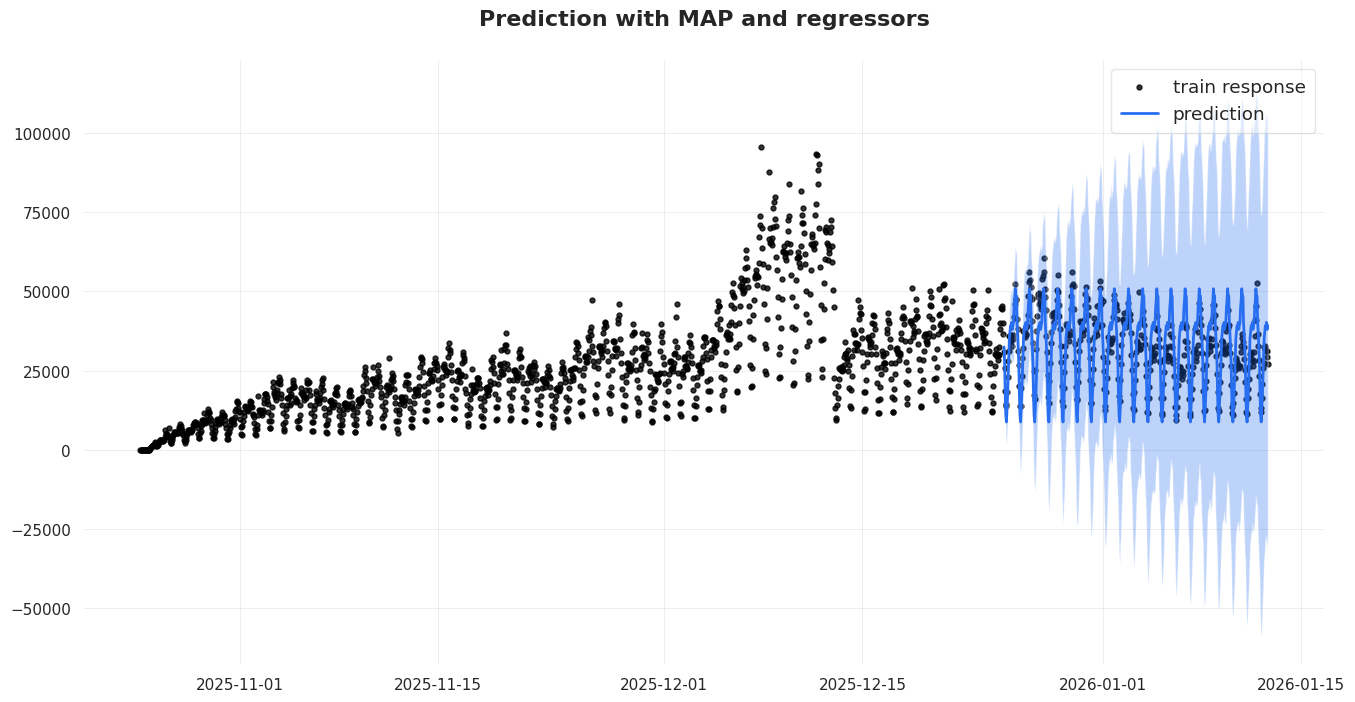

In [51]:
predicted_df_reg = reg_map.predict(df=test_df)

_ = plot_predicted_data(df, predicted_df_reg, "hour_time", 'hour_action', title='Prediction with MAP and regressors') 

In [52]:
#decompositions
predicted_df = reg_map.predict(df=test_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-12-25 00:00:00,28906.111835,32448.729294,36149.409210,29359.648835,32902.266294,36602.946210,-453.537,-453.537,-453.537,0.0,0.0,0.0
1,2025-12-25 01:00:00,22815.044188,27700.196423,32615.057733,28017.114188,32902.266423,37817.127733,-5202.070,-5202.070,-5202.070,0.0,0.0,0.0
2,2025-12-25 02:00:00,12043.169079,17612.766552,23381.946737,27332.669079,32902.266552,38671.446737,-15289.500,-15289.500,-15289.500,0.0,0.0,0.0
3,2025-12-25 03:00:00,4994.942532,10967.466682,17336.331478,26929.742532,32902.266682,39271.131478,-21934.800,-21934.800,-21934.800,0.0,0.0,0.0
4,2025-12-25 04:00:00,2066.715382,8803.966811,15887.568954,26165.015382,32902.266811,39985.868954,-24098.300,-24098.300,-24098.300,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

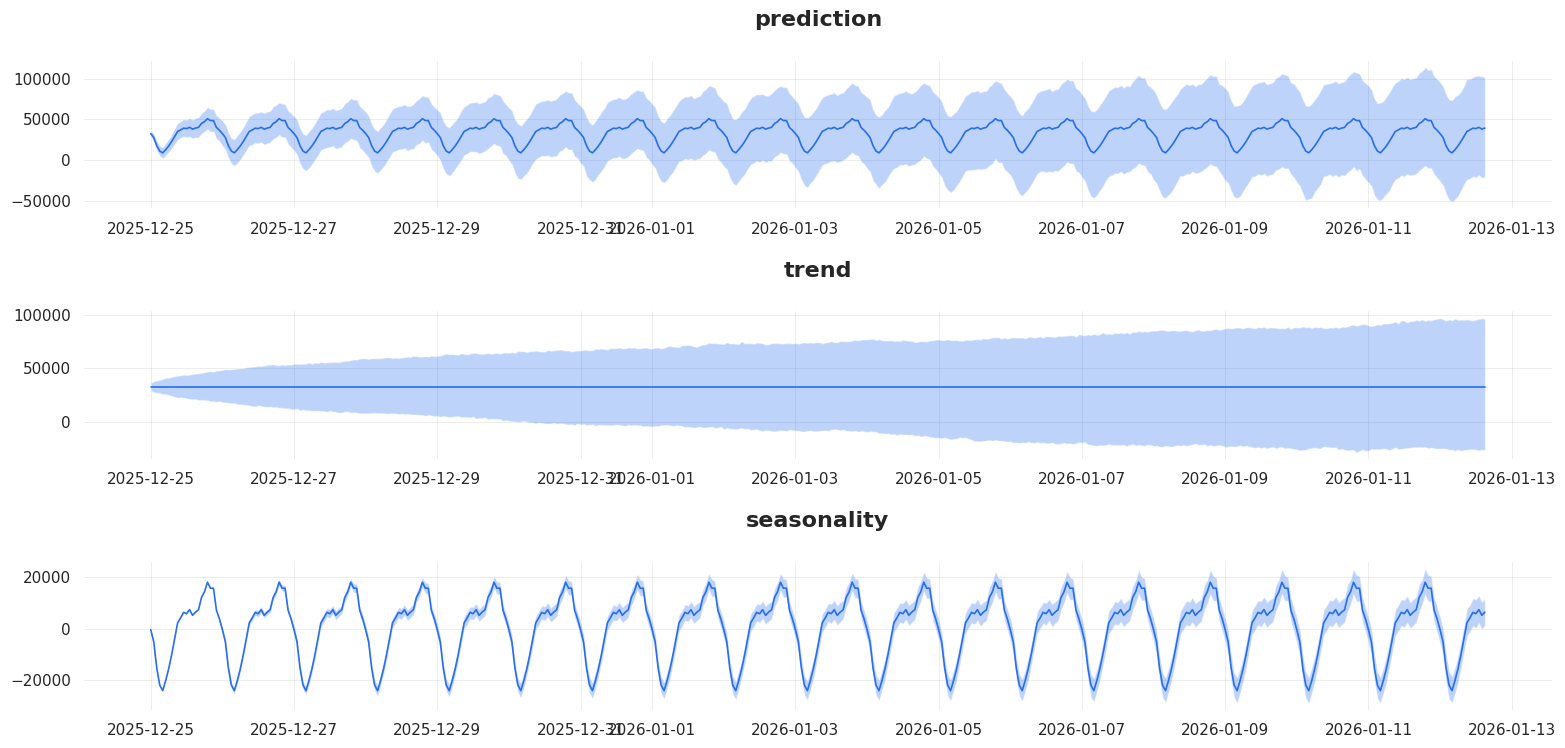

In [53]:
#decoomposition plot
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

### Backtest for model 5

In [54]:
models = {
    "DLT_base_with regressors": reg_map
}

metrics_df = backtest_models(
    models=models,
    data=df,
    min_train_len=24*7*4,
    incremental_len=24*7,
    forecast_len=24*7
)


===== Backtesting model: DLT_base_with regressors =====


,metric_name,metric_values,is_training_metric,model
0,smape,2.189892e-01,False,DLT_base_with regressors
1,wmape,2.331390e-01,False,DLT_base_with regressors
2,mape,2.422385e-01,False,DLT_base_with regressors
3,mse,1.213260e+08,False,DLT_base_with regressors
4,mae,7.856248e+03,False,DLT_base_with regressors
5,rmsse,2.233563e+00,False,DLT_base_with regressors


And BIC for the same model:

In [55]:
print(f"DLT, stan-map with regressors: {reg_map.get_bic()}")

DLT, stan-map with regressors: 27201.626357213263


MSE for the prediction is close to MSE obtained for models 1-4, but BIC is smaller which means, the model is beter. Let's change estimator for stan-mcmc since it is expected to get more accurate results with this estimator and validate the model.

### Model 6: DLT with MCMC and regressors

Since DLT with stan-map model is fast, but not accurate, we try Markov Chain Monte Carlo (MCMC) method. MCMC is known for accurate forecast in contrast to DLT with stan-map, however it slows down calculations. 

In [56]:
reg_mcmc = DLT(seasonality=24, 
               response_col="hour_action", 
               date_col="hour_time", 
               estimator='stan-mcmc',
               regression_penalty='auto_ridge',
               n_bootstrap_draws=1000,
               regressor_col=['advertisement', 'flashmob', 'problems', 'holiday'],
               num_warmup=2000, #'warmup time'
               num_sample=1000) #sampling time


In [57]:
reg_mcmc.fit(train_df) #train the model

2026-01-12 12:52:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

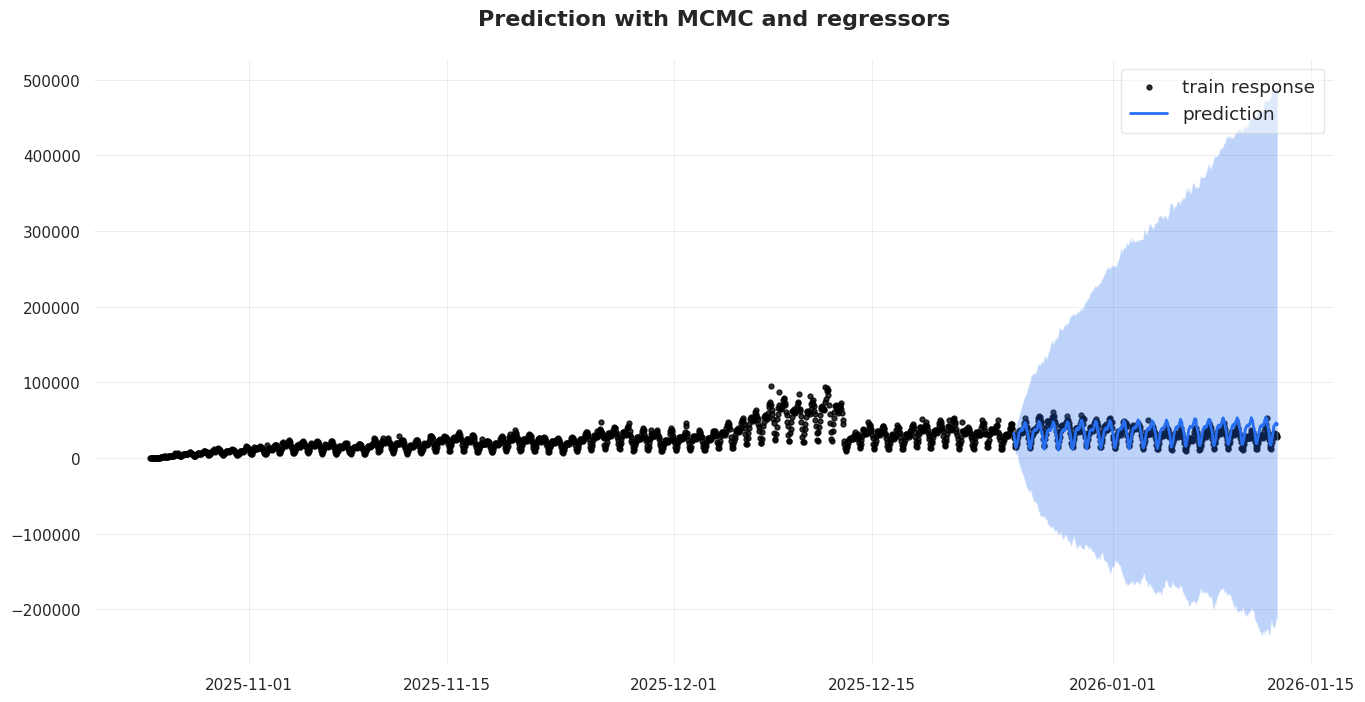

In [58]:
predicted_df_reg = reg_mcmc.predict(df=test_df)

_ = plot_predicted_data(df, predicted_df_reg, "hour_time", 'hour_action', title='Prediction with MCMC and regressors') 

In [59]:
#decompositions
predicted_df = reg_mcmc.predict(df=test_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-12-25 00:00:00,28393.976408,32581.213523,36531.656054,28929.587729,33283.501805,37253.855338,-1528.030,-747.4385,1097.980,0.0,0.0,0.0
1,2025-12-25 01:00:00,22651.403223,28562.158386,35717.800794,24377.970744,31759.705029,37665.770323,-6143.279,-844.3450,-601.020,0.0,0.0,0.0
2,2025-12-25 02:00:00,13001.213366,21082.938828,36384.987957,18715.442787,30928.182919,39352.959819,-16067.600,-1854.0350,-1363.500,0.0,0.0,0.0
3,2025-12-25 03:00:00,5573.175425,16263.899251,38850.010098,13384.029638,30508.808896,40561.769553,-22639.440,-917.1750,-537.648,0.0,0.0,0.0
4,2025-12-25 04:00:00,2611.810321,14607.145635,43470.751876,9740.663320,30275.905990,42687.095612,-24784.500,1425.1900,1784.846,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

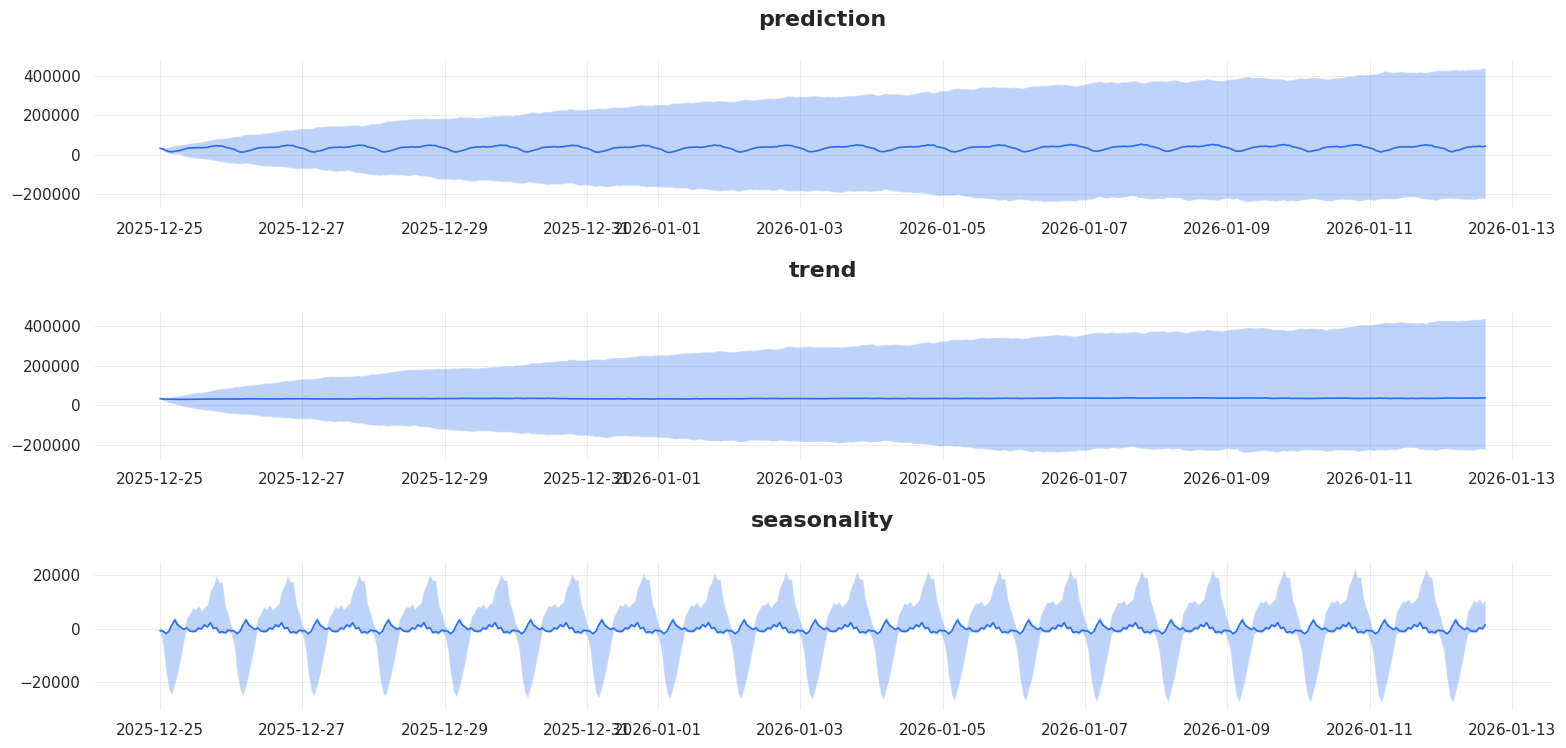

In [60]:
#decoomposition plot
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

#### Chain test for mcmc
It is important to check how well MCMC has “converged". This means that different instances of the algorithm
have come to the same conclusion in terms of parameters


In [61]:
params = reg_mcmc.get_posterior_samples(permute=False) #parameters

params.keys() 

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'beta', 'gt_sum', 'gb', 'gl', 'loglk'])

In [62]:
params["obs_sigma"].shape 

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

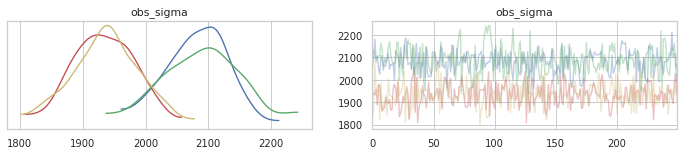

In [63]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

All chains are giving different results. Based on previous experiments we saw that laso regression may give better outcome. We are going to train the model again. This model will not be evaluated with backtest.

### Model 7: MCMC with lasso

In [64]:
reg_mcmc_ls = DLT(seasonality=24, 
               response_col="hour_action", 
               date_col="hour_time", 
               estimator='stan-mcmc',
               regression_penalty='lasso',
               n_bootstrap_draws=1000,
               regressor_col=['advertisement', 'flashmob', 'problems', 'holiday'],
               num_warmup=2000, #'warmup time'
               num_sample=1000) #sampling time

In [65]:
reg_mcmc_ls.fit(train_df) #train the model

2026-01-12 12:57:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

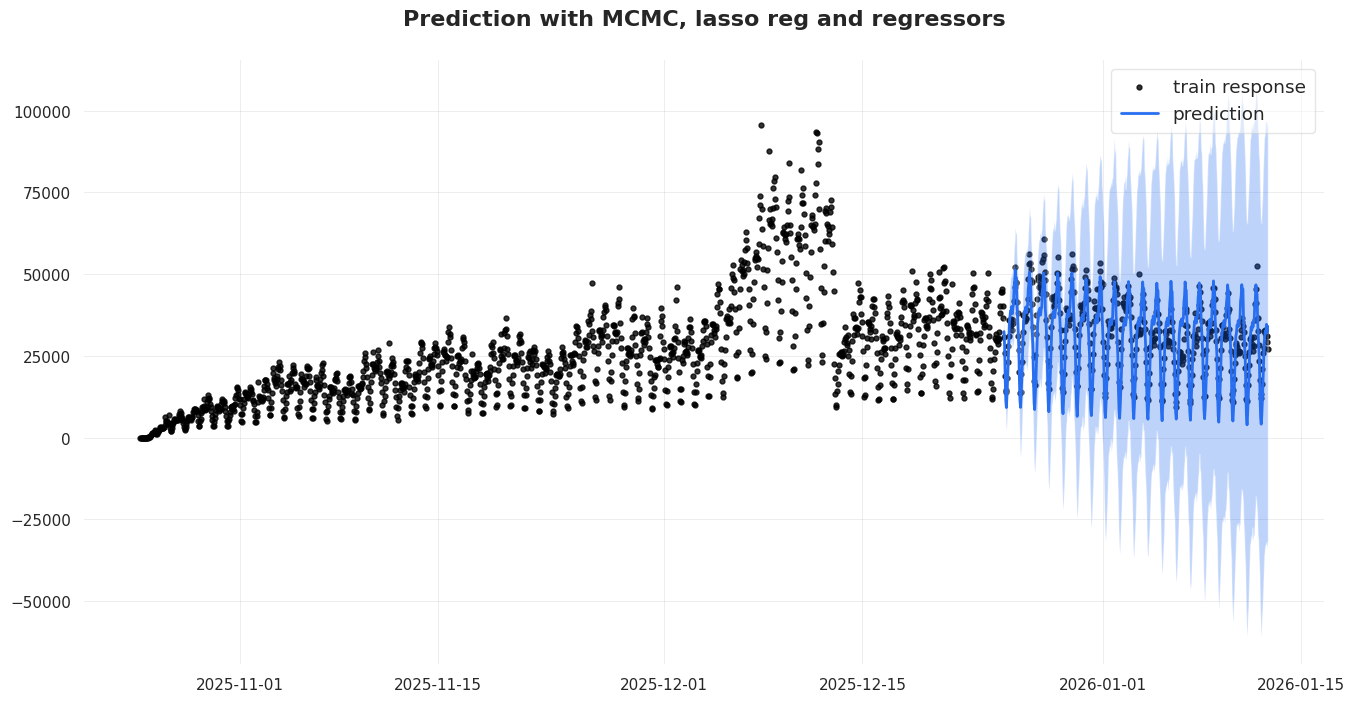

In [66]:
predicted_df_reg = reg_mcmc_ls.predict(df=test_df)

_ = plot_predicted_data(df, predicted_df_reg, "hour_time", 'hour_action', title='Prediction with MCMC, lasso reg and regressors') 

In [67]:
#decompositions
predicted_df = reg_mcmc_ls.predict(df=test_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-12-25 00:00:00,28803.312500,32407.394419,35943.821304,28725.174708,32703.925070,36702.906248,-1945.9255,-365.889,1389.5170,0.0,0.0,0.0
1,2025-12-25 01:00:00,22806.794907,27647.666514,32581.117613,27615.792416,32615.521819,38004.911676,-6620.3570,-5015.820,-3255.7855,0.0,0.0,0.0
2,2025-12-25 02:00:00,12393.089331,17766.841086,23563.681925,27167.402241,32731.099690,38828.738398,-16575.1350,-14959.900,-13187.8050,0.0,0.0,0.0
3,2025-12-25 03:00:00,5055.973507,11165.207404,17701.595428,26497.763308,32645.751204,39016.853311,-23196.8350,-21518.300,-19760.6500,0.0,0.0,0.0
4,2025-12-25 04:00:00,2277.901811,9025.106344,15660.160027,25739.342878,32557.064044,39805.610454,-25357.9000,-23631.050,-21899.5450,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

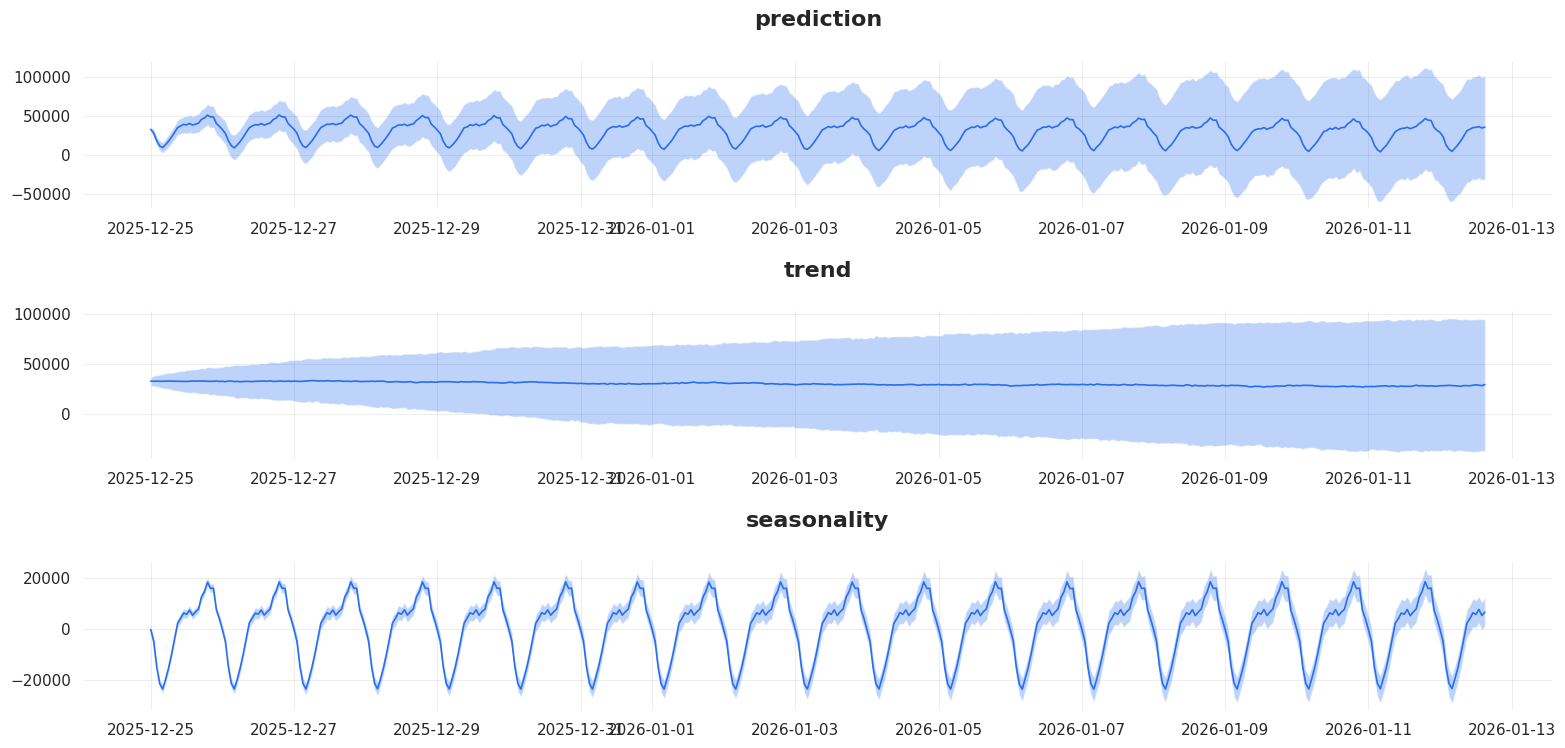

In [68]:
#decoomposition plot
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

#### Chain test, mcmc with lasso

In [69]:
params = reg_mcmc_ls.get_posterior_samples(permute=False) 

params.keys() 

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'beta', 'gt_sum', 'gb', 'gl', 'loglk'])

In [70]:
params["obs_sigma"].shape 

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

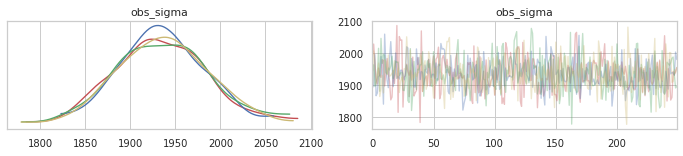

In [71]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

All chains are close to the same value, which is good. Let's validate the model prediction


### Backtest, model 7

In [72]:
models = {
    "DLT_MCMC_with_regressors_and_lasso_rp": reg_mcmc_ls
}

metrics_df = backtest_models(
    models=models,
    data=df,
    min_train_len=24*7*4,
    incremental_len=24*7,
    forecast_len=24*7
)


2026-01-12 12:59:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.



===== Backtesting model: DLT_MCMC_with_regressors_and_lasso_rp =====


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-12 13:00:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-12 13:01:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-12 13:02:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-12 13:04:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-12 13:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2026-01-12 13:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric,model
0,smape,2.351031e-01,False,DLT_MCMC_with_regressors_and_lasso_rp
1,wmape,2.483605e-01,False,DLT_MCMC_with_regressors_and_lasso_rp
2,mape,2.536009e-01,False,DLT_MCMC_with_regressors_and_lasso_rp
3,mse,1.366172e+08,False,DLT_MCMC_with_regressors_and_lasso_rp
4,mae,8.369178e+03,False,DLT_MCMC_with_regressors_and_lasso_rp
5,rmsse,2.370139e+00,False,DLT_MCMC_with_regressors_and_lasso_rp


And WBIC to check model's quality:

In [73]:
reg_mcmc.fit_wbic(train_df)

2026-01-12 13:10:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 7.289, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

27336.957748967674

# Conclusion

- Based on results obtained DLS with stan-map and regressors model (#5) is giving the best results. At the same time, the model is much faster that DLT with stan-mcmc estimator, lasso regression penalty, and regressors. However, *the prediction overal is not really good and all models demonstrate high volatility* (bigger than error we've seen on the original data) for 1 month prediction.  
- Moreover, we did not have enough data for backtest, therefore, we used 4 weeks initial train length and 1 week forecast length

Answer to bonus question: I can't say if orbit is convinient to use compared to other instruments since I've never use any of those.